# MPI Jena Weather Dataset

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from pathlib import Path
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

base_dir = Path(".").absolute().parents[0]
import sys

if sys.path[0] != base_dir.as_posix():
    sys.path = [base_dir.as_posix()] + sys.path

In [2]:
from spatio_temporal.config import Config
from spatio_temporal.training.trainer import Trainer
from spatio_temporal.training.tester import Tester
from tests.utils import (
    create_linear_ds,
    _test_sklearn_model,
    download_test_jena_data,
    load_test_jena_data_as_dataset
)
from spatio_temporal.training.eval_utils import _plot_loss_curves, save_losses

# Load in Data

In [3]:
if not (base_dir / "data/jena_climate_2009_2016.csv").exists():
    download_test_jena_data(base_dir / "data")

In [4]:
ds = load_test_jena_data_as_dataset(base_dir / "data")

# Load in config file

In [5]:
cfg = Config(base_dir / "tests/testconfigs/jena.yml")
cfg._cfg["n_epochs"] = 10
cfg._cfg["autoregressive"] = True
cfg._cfg["horizon"] = 2
cfg._cfg["seq_length"] = 48
cfg._cfg["scheduler"] = "cycle"
cfg._cfg["optimizer"] = "AdamW"
cfg._cfg["hidden_size"] = "10"

#  NOTE: this means we are testing on the train period!
# Swap test, train periods
# test_start = cfg._cfg["test_start_date"]
# test_end = cfg._cfg["test_end_date"]
# cfg._cfg["test_start_date"] = cfg._cfg["train_start_date"]
# cfg._cfg["test_end_date"] = cfg._cfg["train_end_date"]

# cfg._cfg["train_start_date"] = test_start
# cfg._cfg["train_end_date"] = test_end
cfg

{'autoregressive': True,
 'batch_size': 30,
 'data_dir': PosixPath('data'),
 'experiment_name': 'jena',
 'hidden_size': '10',
 'horizon': 2,
 'input_variables': ['p (mbar)', 'rh (%)'],
 'learning_rate': 0.01,
 'loss': 'MSE',
 'n_epochs': 10,
 'num_workers': 4,
 'optimizer': 'AdamW',
 'pixel_dims': ['pixel'],
 'run_dir': None,
 'scheduler': 'cycle',
 'seed': 1234,
 'seq_length': 48,
 'target_variable': 'T (degC)',
 'test_end_date': Timestamp('2009-07-06 00:00:00'),
 'test_start_date': Timestamp('2009-01-06 00:00:00'),
 'train_end_date': Timestamp('2009-01-05 00:00:00'),
 'train_start_date': Timestamp('2009-01-02 00:00:00'),
 'validation_end_date': Timestamp('2009-01-02 00:00:00'),
 'validation_start_date': Timestamp('2009-01-01 00:00:00')}

### Interesting that the train/test period are so different

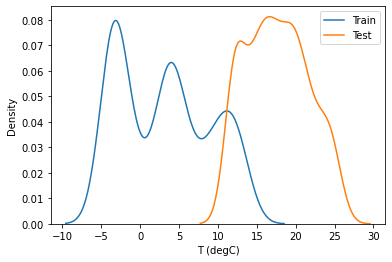

In [6]:
test = ds.isel(pixel=0).sel(time=slice(cfg._cfg["test_start_date"], cfg._cfg["test_end_date"]))
train = ds.isel(pixel=0).sel(time=slice(cfg._cfg["train_start_date"], cfg._cfg["train_end_date"]))

sns.kdeplot(train[cfg.target_variable], label="Train")
sns.kdeplot(test[cfg.target_variable], label="Test")
plt.legend()

# Create trainer

In [7]:
trainer = Trainer(cfg, ds)

Loading Data: 100%|██████████| 1/1 [00:00<00:00, 301.92it/s]


In [8]:
losses = trainer.train_and_validate()

Training Epoch 2:   0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 1.02
Valid Loss: 2.80


Training Epoch 3:   0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.83
Valid Loss: 2.75


Training Epoch 4:   0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.67
Valid Loss: 2.58


Training Epoch 5:   0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.50
Valid Loss: 2.55


Training Epoch 6:   0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.39
Valid Loss: 2.45


Training Epoch 7:   0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.27
Valid Loss: 2.08


Training Epoch 8:   0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.21
Valid Loss: 1.67


Training Epoch 9:   0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.17
Valid Loss: 1.18


Training Epoch 10:   0%|          | 0/13 [00:00<?, ?it/s]

Train Loss: 0.12
Valid Loss: 0.61


Validation Epoch 10: 100%|██████████| 4/4 [00:01<00:00,  2.21it/s]

Train Loss: 0.10
Valid Loss: 0.36


# Check losses of trained model

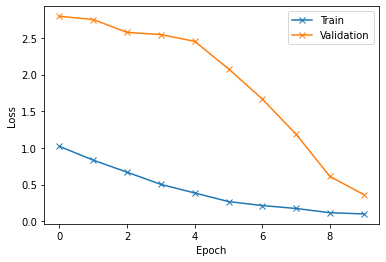

In [9]:
train_losses, valid_losses = losses
f, ax = plt.subplots()
ax.plot(train_losses, label="Train", color="C0", marker="x")
ax.plot(valid_losses, label="Validation", color="C1", marker="x")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
plt.legend()

# Run Evaluation

In [10]:
# ds.sel(time=slice(cfg.test_start_date, cfg.test_end_date))
print(ds.time.min())
print(ds.time.max())

In [11]:
tester = Tester(cfg, ds)

Loading Data: 100%|██████████| 1/1 [00:00<00:00, 252.65it/s]


Test set Forward Pass: 100%|██████████| 8/8 [00:01<00:00,  4.57it/s]


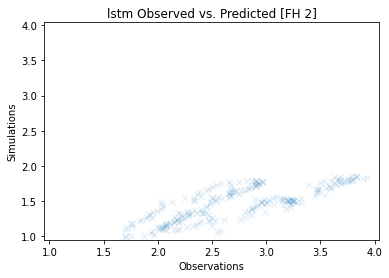

In [12]:
_ = tester.run_test(unnormalize=False)

### check normalisations

In [13]:
true_mean = ds.sel(time=slice(cfg.train_start_date, cfg.train_end_date))[cfg.input_variables + [cfg.target_variable]].mean().to_array().values
calc_mean = trainer.train_dl.dataset.normalizer.mean_.to_array().values

assert np.allclose(true_mean.flatten(), calc_mean.flatten())

# The output forecasts! 

In [14]:
xr_path = sorted(list(cfg.run_dir.glob("*.nc")))[-1]
preds = xr.open_dataset(xr_path).drop(["horizon"])
preds

<xarray.Dataset>
Dimensions:  (horizon: 1, pixel: 1, time: 230)
Coordinates:
  * time     (time) datetime64[ns] 2009-01-06T08:19:19.687634944 ... 2009-01-...
  * pixel    (pixel) object '1_1'
Dimensions without coordinates: horizon
Data variables:
    sim      (time, horizon, pixel) float32 ...
    obs      (time, horizon, pixel) float32 ...

- there seems to be a normalisation problem
- Missing the scale of the observations

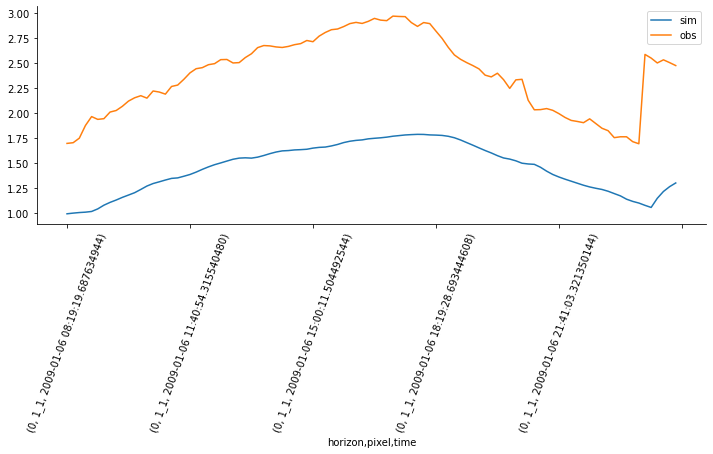

In [15]:
# .sel(time=slice("2015-01-01", "2015-02-01"))
f, ax = plt.subplots(figsize=(12, 4))
preds.isel(time=slice(0, 100)).to_dataframe().plot(ax=ax)

# artificial improvement
# ((ds.isel(time=slice(0, 100)).to_dataframe()["sim"] ** 6)).plot(ax=ax)

plt.xticks(rotation=70);
sns.despine()

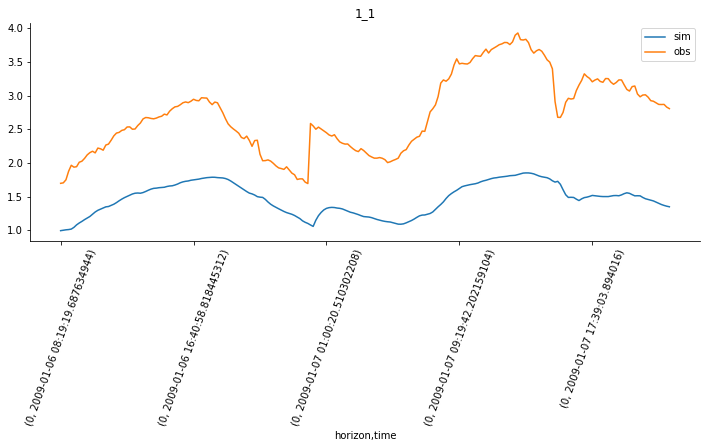

In [16]:
# .sel(time=slice("2015-01-01", "2015-02-01"))
f, ax = plt.subplots(figsize=(12, 4))
pixel = np.random.choice(preds.pixel.values)
preds.sel(pixel=pixel).to_dataframe().plot(ax=ax)
ax.set_title(pixel)
plt.xticks(rotation=70);
sns.despine()